In [2]:
import numpy as np
import torch as th
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import copy
import seaborn as sns
import scipy
from scipy.stats import skew, kurtosis
from scipy.stats import wasserstein_distance, gaussian_kde
from statsmodels.tsa.stattools import acf
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_util import make_vec_env
sns.set_style("whitegrid", rc={"grid.alpha": 0.5})

/Users/fzejnu/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
def generate_ar_sequences_and_deltas(phi_coeffs, sequence_length, n_sequences, sigma=1.0, initial_values=None):
    """
    Generate AR(p) price sequences and their deltas.
    The delta sequences will be one step shorter than the price sequences.
    
    Args:
        phi_coeffs: List of AR coefficients [φ₁, φ₂, ..., φₚ]
        sigma: Standard deviation of the noise term
        sequence_length: Length of price sequence (deltas will be length-1)
        n_sequences: Number of sequences to generate
        initial_values: Starting values for each sequence (optional)
    
    Returns:
        tuple: (price_sequences, delta_sequences)
        - price_sequences shape: (n_sequences, sequence_length)
        - delta_sequences shape: (n_sequences, sequence_length-1)
    """
    p = len(phi_coeffs)  # AR order
    
    # Check stationarity
    roots = np.roots(np.r_[1, -np.array(phi_coeffs)])
    if not np.all(np.abs(roots) > 1):
        print("Warning: AR coefficients may lead to non-stationary process")
    
    price_sequences = []
    delta_sequences = []
    
    for _ in range(n_sequences):
        # Initialize price sequence
        prices = np.zeros(sequence_length)
        prices[0] = 100  # Starting price
        
        # Generate AR process for returns
        returns = np.zeros(sequence_length-1)  # One less return than prices
        
        # Set initial values for returns
        if initial_values is not None:
            returns[:p] = initial_values[:p]
        else:
            returns[:p] = np.random.normal(0, sigma, p)
        
        # Generate returns using AR process
        for t in range(p, sequence_length-1):
            # AR terms
            ar_component = sum(phi * returns[t-i-1] for i, phi in enumerate(phi_coeffs))
            
            # Add noise
            noise = np.random.normal(0, sigma)
            
            # Combine
            returns[t] = ar_component + noise
        
        # Convert returns to prices
        for t in range(1, sequence_length):
            prices[t] = prices[t-1] * (1 + returns[t-1])
        
        # Calculate price deltas
        deltas = np.diff(prices)
        
        price_sequences.append(prices)
        delta_sequences.append(deltas)
    
    return np.array(price_sequences), np.array(delta_sequences)

def tokenize_deltas(data, bin_start, bin_stop, bin_width):
    # Assuming data is a NumPy array of shape (n_sequences, seq_length)
    n_sequences, seq_length = data.shape

    # Bin range and Bin width
    num_bins = int((bin_stop - bin_start) / bin_width)  # Calculate number of bins
    bin_edges = np.arange(bin_start, bin_stop + bin_width, bin_width)

    # Tokenize each sequence individually (no flattening)
    tokenized_sequences = np.empty_like(data)

    for i in range(n_sequences):
        tokenized_data = np.digitize(data[i], bins=bin_edges, right=False) - 1
        tokenized_sequences[i] = np.clip(tokenized_data, 0, num_bins - 1)

    # Split the data based on 60/20/20 ratio
    train_size = int(0.6 * n_sequences)
    val_size = int(0.2 * n_sequences)
    
    train_data = tokenized_sequences[:train_size]  # First 60% of sequences for training
    val_data = tokenized_sequences[train_size:train_size + val_size]  # Next 20% for validation
    test_data = tokenized_sequences[train_size + val_size:]  # Remaining 20% for testing

    print('Number of Tokens:', num_bins)
    print('Training Data Shape:', train_data.shape)
    print('Validation Data Shape:', val_data.shape)
    print('Test Data Shape:', test_data.shape)

    return train_data, val_data, test_data, num_bins

def calculate_statistics(trajectories):
    means = []
    variances = []
    std_devs = []
    skewness = []
    kurtos = []
    max_vals = []
    min_vals = []

    for traj in trajectories:
        means.append(np.mean(traj))
        variances.append(np.var(traj))
        std_devs.append(np.std(traj))
        skewness.append(skew(traj))
        kurtos.append(kurtosis(traj))
    
    return means, variances, std_devs, skewness, kurtos

def calculate_entropy(sequence):
    
    # Get unique values and their counts in one pass
    values, counts = np.unique(sequence, return_counts=True)
    
    # Calculate probabilities using vectorized operation
    probabilities = counts / len(sequence)
    
    # Calculate entropy vectorized with numerical stability
    # Using log(p) directly is stable when p > 0
    entropy = -np.sum(probabilities * np.log(probabilities))
    
    return entropy

def plot_price_hist(price, deltas, bin_width):
    fig, axs = plt.subplots(1, 3, figsize=(18, 3.5))

    # Histogram: GBM Prices
    axs[0].hist(np.concatenate(price), bins=20, color='blue', density=True)
    axs[0].set_title('Histogram: GBM Prices')
    axs[0].set_xlabel('Price')
    axs[0].set_ylabel('Frequency')

    bins = np.arange(-5.1, 5.1 + bin_width, bin_width)

    # Histogram: GBM Price Deltas
    axs[1].hist(np.concatenate(deltas), 
                bins=bins, 
                edgecolor='orange', color='blue', density=True)
    axs[1].set_title('Histogram: GBM Price Deltas')
    axs[1].set_xlabel('Price Difference')
    axs[1].set_ylabel('Frequency')

    # Boxplot Price Deltas
    axs[2].boxplot(np.concatenate(deltas), vert=False)
    axs[2].set_title('Boxplot Price Deltas')
    axs[2].set_xlabel('Price Difference')
    plt.tight_layout()
    plt.show()

def plot_losses(pg_loss, value_loss, entropy_loss):

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (18,3))
    axs = axs.flatten()
    
    axs[0].plot(pg_loss, color='blue')
    axs[0].set_title('Policy Loss')
    axs[0].set_xlabel('Model Update')
    axs[0].set_ylabel('Value')

    axs[1].plot(value_loss, color='blue')
    axs[1].set_title('Value Loss')
    axs[1].set_xlabel('Model Update')
    axs[1].set_ylabel('Value')

    axs[2].plot(entropy_loss, color='blue')
    axs[2].set_title('Entropy Loss')
    axs[2].set_xlabel('Model Update')
    axs[2].set_ylabel('Value')
    
    #plt.tight_layout()
    plt.show()

def plot_rewards(ep_rew, ep_len=None, ep_time=None):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (18,3))
    axs = axs.flatten()
    
    axs[0].plot(ep_rew, color='blue')
    axs[0].set_title('Episode Reward')
    axs[0].set_ylabel('Reward')
    axs[0].set_xlabel('Model Update')
    #axs[0].set_ylim(-12,0)

    axs[1].plot(ep_len, color='blue')
    axs[1].set_title('Episode Length')
    axs[1].set_ylabel('Length')
    axs[1].set_xlabel('Episode')

    axs[2].plot(ep_time, color='blue')
    axs[2].set_title('Episode Time in Sec.')
    axs[2].set_ylabel('Time')
    axs[2].set_xlabel('Episode')

    plt.show()

def plot_discriminator(kl_div, disc_acc, disc_loss):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (18,3))
    axs = axs.flatten()

    axs[0].plot(kl_div, color='blue')
    axs[0].set_title('KL Div. real vs. sim sequences')
    axs[0].set_ylabel('KL Divergence')
    axs[0].set_xlabel('Model Update')

    axs[1].plot(disc_acc, color='blue')
    axs[1].set_title('Discriminator Accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Model Update')
    axs[1].set_ylim(0,1)

    axs[2].plot(disc_loss, color='blue')
    axs[2].set_title('Discriminator Loss')
    axs[2].set_ylabel('Loss')
    axs[2].set_xlabel('Model Update')

    plt.show()


In [19]:
def analyze_timestep_distributions(real_sequences, generated_sequences):
    """
    Analyze and compare distributions at each timestep.
    
    Args:
        real_sequences: numpy array of shape (n_sequences, sequence_length)
        generated_sequences: numpy array of shape (n_sequences, sequence_length)
    
    Returns:
        dict containing wasserstein distances and plot figure
    """
    n_timesteps = real_sequences.shape[1]
    
    # Calculate Wasserstein distance for each timestep
    wasserstein_distances = []
    for t in range(n_timesteps):
        w_dist = wasserstein_distance(real_sequences[:, t], generated_sequences[:, t])
        wasserstein_distances.append(w_dist)
    
    # Create visualization
    fig = plt.figure(figsize=(15, 7))
    
    # 1. Main grid for plots
    gs = plt.GridSpec(2, 2)
    
    # Plot 1: Wasserstein distances over time
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(wasserstein_distances, marker='o')
    ax1.set_title('Wasserstein Distance by Timestep')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('Wasserstein Distance')
    
    # Plot 2: Compare specific timesteps
    ax2 = fig.add_subplot(gs[0, 1])
    # Pick timestep with largest Wasserstein distance
    worst_timestep = np.argmax(wasserstein_distances)
    plot_timestep_comparison(real_sequences, generated_sequences, worst_timestep, ax2)
    
    # Plot 3: Distribution evolution heatmap for real sequences
    ax3 = fig.add_subplot(gs[1, 0])
    plot_distribution_evolution(real_sequences, ax3, 'Real Sequences Distribution Evolution')
    
    # Plot 4: Distribution evolution heatmap for generated sequences
    ax4 = fig.add_subplot(gs[1, 1])
    plot_distribution_evolution(generated_sequences, ax4, 'Generated Sequences Distribution Evolution')
    
    plt.tight_layout()
    
    return {
        'wasserstein_distances': wasserstein_distances,
        'figure': fig,
        'worst_timestep': worst_timestep,
        'mean_wasserstein': np.mean(wasserstein_distances)
    }

def plot_distribution_evolution(sequences, ax, title):
    """
    Create a heatmap showing how distribution evolves over time.
    """
    n_timesteps = sequences.shape[1]
    bins = 50
    
    # Calculate histogram for each timestep
    hist_data = []
    for t in range(n_timesteps):
        hist, bin_edges = np.histogram(sequences[:, t], bins=bins, 
                                     density=True, range=(sequences.min(), sequences.max()))
        hist_data.append(hist)
    
    # Create heatmap
    sns.heatmap(np.array(hist_data).T, ax=ax, cmap='viridis')
    ax.set_title(title)
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Value Distribution')

def plot_timestep_comparison(real_sequences, generated_sequences, timestep, ax):
    """
    Compare distributions at a specific timestep using KDE.
    """
    # Get data for the specified timestep
    real_data = real_sequences[:, timestep]
    generated_data = generated_sequences[:, timestep]
    
    # Calculate KDE
    kde_real = gaussian_kde(real_data)
    kde_generated = gaussian_kde(generated_data)
    
    # Create evaluation points
    x_eval = np.linspace(min(real_data.min(), generated_data.min()),
                        max(real_data.max(), generated_data.max()),
                        200)
    
    # Plot distributions
    ax.plot(x_eval, kde_real(x_eval), label='Real', color='blue')
    ax.plot(x_eval, kde_generated(x_eval), label='Generated', color='orange')
    ax.set_title(f'Distribution Comparison at Timestep {timestep}\n'
                f'(Largest Wasserstein Distance)')
    ax.legend()

def detailed_distribution_stats(real_sequences, generated_sequences):
    """
    Calculate detailed statistics for each timestep.
    """
    n_timesteps = real_sequences.shape[1]
    stats = []
    
    for t in range(n_timesteps):
        real_t = real_sequences[:, t]
        gen_t = generated_sequences[:, t]
        
        stat = {
            'timestep': t,
            'real_mean': np.mean(real_t),
            'gen_mean': np.mean(gen_t),
            'real_std': np.std(real_t),
            'gen_std': np.std(gen_t),
            'real_skew': scipy.stats.skew(real_t),
            'gen_skew': scipy.stats.skew(gen_t),
            'wasserstein': wasserstein_distance(real_t, gen_t),
            'ks_stat': scipy.stats.ks_2samp(real_t, gen_t).statistic
        }
        stats.append(stat)
    
    return stats

In [7]:
S0 = 100                # Initial stock price
mu = 0.1                # Annual drift
sigma = 0.2             # Volatility
n_days = 12             # Sequence length (52 days)
n_sequences = 50000     # Number of sequences to simulate

Price_GBM, Delta_GBM = generate_ar_sequences_and_deltas(
    phi_coeffs = [0.4, 0.3, 0.2, 0.1, 0.05],
    sigma=0.01,
    sequence_length=n_days,
    n_sequences=50000
)


Standard Deviation of Price Deltas: 1.23
BIN WIDTH:  0.25


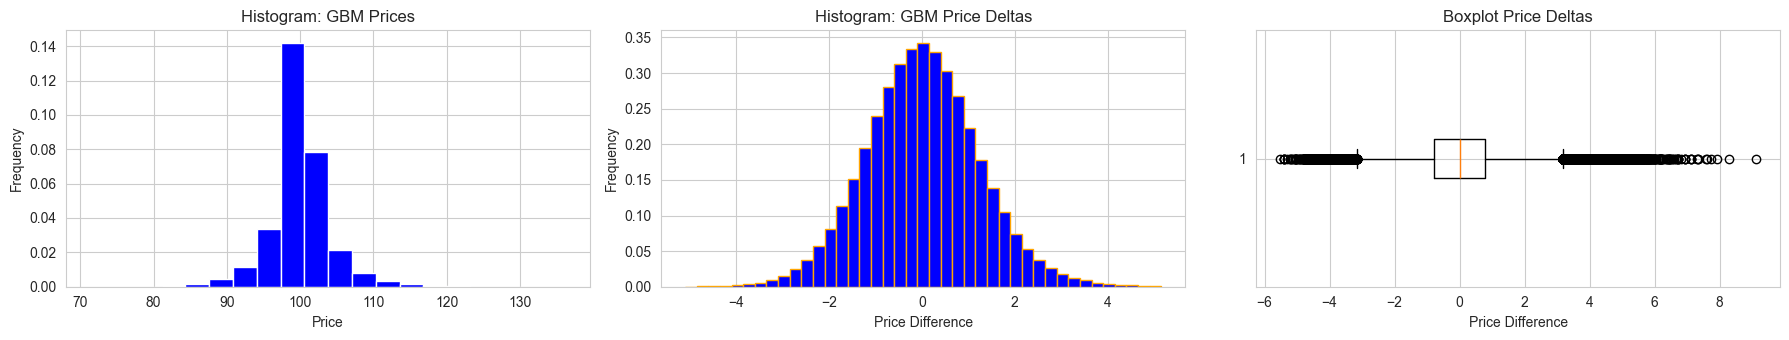

Number of Tokens: 40
Training Data Shape: (30000, 11)
Validation Data Shape: (10000, 11)
Test Data Shape: (10000, 11)


In [8]:
bin_width = 0.25
print('Standard Deviation of Price Deltas:', np.round(np.std(Delta_GBM.flatten()),3))
print('BIN WIDTH: ', bin_width)
plot_price_hist(Price_GBM, Delta_GBM, bin_width)

train_data, val_data, test_data, token_size = tokenize_deltas(Delta_GBM, bin_start=-5.0, bin_stop=5.0, bin_width=bin_width)

In [9]:
class Discriminator(nn.Module):
    def __init__(self, sequence_length, hidden_size):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(sequence_length, hidden_size),            # First layer:              10 -> 256
            nn.ReLU(),                                      
            nn.Linear(hidden_size, hidden_size // 2),           # Second layer:             256 -> 128
            nn.ReLU(),                                      
            nn.Linear(hidden_size // 2, hidden_size // 4),      # Third layer:              128 -> 64
            nn.ReLU(),
            nn.Linear(hidden_size // 4, hidden_size // 8),      # Fourth layer:             64 -> 32
            nn.ReLU(),
            nn.Linear(hidden_size // 8, hidden_size // 16),      # Fourth layer:             64 -> 32
            nn.ReLU(),                                                                          
            nn.Linear(hidden_size // 16, 1)                      # Output layer (Logits)     32 -> 1
        )
    def forward(self, x):
        # x shape: [batch_size, sequence_length]
        return self.network(x)
    
class CustomEnv(gym.Env):
    
    def __init__(self, train_data, token_size, discriminator, d_optimizer, d_train_auto, d_max_updates):
        
        super(CustomEnv, self).__init__()
        
        # Spaces
        self.action_space = spaces.Discrete(token_size)        # Action Space
        self.observation_space = spaces.Discrete(token_size)   # Observation Spacepass

        # Data
        self.train_data = train_data
        
        # Reset
        self.seq_len = None
        self.curr_sim = []
        self.seq_position = 0
    
        # Just to compare KL in training
        self.real_train_seq = []
        self.sim_train_seq = []

        # Discriminator
        self.discriminator = discriminator
        self.d_optimizer = d_optimizer
        self.criterion = nn.BCEWithLogitsLoss()

        # Discriminator auto training
        self.d_max_updates = d_max_updates
        self.target_acc_idx = 0

        if d_train_auto:
            self.train_discriminator = self.train_discriminator_auto
        else:
            self.train_discriminator = self.train_discriminator_fixed

    def step(self, action):

        assert self.action_space.contains(action), "Invalid Action"

        self.seq_position += 1

        self.curr_sim.append(action)

        done = self._is_done()

        ###=====REWARD=====###
        if done:
            reward = self._get_reward()
            self.sim_train_seq.append(self.curr_sim)
        else:
           reward = 0
        ###=====REWARD=====###

        next_obs = action

        return next_obs, reward, done, False, {}        # observation, reward, done, truncated, info

    def reset(self, *, seed = None, options = None):
        
        seq_idx = np.random.choice(len(self.train_data), size = 1).item()
        real_seq = self.train_data[seq_idx]

        self.real_train_seq.append(real_seq[1:])
        
        # Reset
        self.seq_len = len(real_seq)
        self.curr_sim = []
        self.seq_position = 0
        
        start_token = int(real_seq[0])

        return start_token, {}

    def _is_done(self):

        return self.seq_position == (self.seq_len - 1)

    def _get_reward(self):

        self.discriminator.eval()

        with th.no_grad():
            temp_sequence = th.tensor(np.array(self.curr_sim), dtype=th.float32)
            prediction = self.discriminator(temp_sequence)
            label = th.ones_like(prediction)
            seq_loss = self.criterion(prediction, label)
            reward = -(seq_loss.item())
            return reward

    def clear_rollout_seq(self):
        self.real_train_seq = []
        self.sim_train_seq = []

    def calculate_kl_div(self):

        real_counts = Counter(np.concatenate(self.real_train_seq))
        fake_counts = Counter(np.concatenate(self.sim_train_seq))
        
        total_real = len(np.concatenate(self.real_train_seq))
        total_fake = len(np.concatenate(self.sim_train_seq))
        
        real_probs = {token: count/total_real for token, count in real_counts.items()}
        fake_probs = {token: count/total_fake for token, count in fake_counts.items()}

        eps = 1e-10  # Small constant for numerical stability
        kl = 0
        for token, p_real in real_probs.items():
            p_fake = fake_probs.get(token, eps)
            if p_real > 0:  # Only compute for non-zero probabilities
                kl += p_real * np.log2(max(p_real, eps) / max(p_fake, eps))
        
        return kl

    def discriminator_accuracy(self, real_data, fake_data):
            
            self.discriminator.eval()

            with th.no_grad():
                
                batch_real = th.tensor(real_data, dtype=th.float32)
                batch_fake = th.tensor(fake_data, dtype=th.float32)

                # Real data
                real_preds = self.discriminator(batch_real)
                real_probs = th.sigmoid(real_preds)
                
                # Fake data
                fake_preds = self.discriminator(batch_fake)
                fake_probs = th.sigmoid(fake_preds)

                correct_real = (real_probs > 0.5).float().sum()
                correct_fake = (fake_probs < 0.5).float().sum()
                
                # Total samples
                total_samples = len(real_probs) + len(fake_probs)
                
                # Overall accuracy
                accuracy = (correct_real + correct_fake) / total_samples
            
            return accuracy.item()

    def train_discriminator_fixed(self):

        discriminator_loss = []
        discriminator_accuracy = []
        
        pre_accuracy = self.discriminator_accuracy(np.array(self.real_train_seq), np.array(self.sim_train_seq))
        
        self.discriminator.train()
        
        for _ in range(self.d_max_updates):
            
            # Data Prep
            real_data = np.array(self.real_train_seq)
            fake_data = np.array(self.sim_train_seq)
            indices = th.randperm(len(fake_data))
            batch_real = th.tensor(real_data[indices], dtype=th.float32)
            batch_fake = th.tensor(fake_data[indices], dtype=th.float32)

            # Real data
            real_preds = self.discriminator(batch_real)
            real_labels = th.ones_like(real_preds)
            real_loss = self.criterion(real_preds, real_labels)

            # Fake data
            fake_preds = self.discriminator(batch_fake)
            fake_labels = th.zeros_like(fake_preds)
            fake_loss = self.criterion(fake_preds, fake_labels)

            # Loss
            d_loss = (real_loss + fake_loss) / 2

            # Model Update
            self.d_optimizer.zero_grad()
            d_loss.backward()
            self.d_optimizer.step()
            
            # Accuracy
            with th.no_grad():
                 # Convert logits to probabilities using sigmoid
                real_probs = th.sigmoid(real_preds)
                fake_probs = th.sigmoid(fake_preds)
                # Count correct predictions
                correct_real = (real_probs > 0.50).float().sum()
                correct_fake = (fake_probs < 0.50).float().sum()
                # Total samples
                total_samples = len(real_probs) + len(fake_probs)
                # Overall accuracy
                accuracy = (correct_real + correct_fake) / total_samples
            
            discriminator_loss.append(d_loss.item())
            discriminator_accuracy.append(accuracy.item())
        
        post_accuracy = self.discriminator_accuracy(np.array(self.real_train_seq), np.array(self.sim_train_seq))
        
        return discriminator_loss, discriminator_accuracy, pre_accuracy, post_accuracy

    def train_discriminator_auto(self):

        discriminator_loss = []
        discriminator_accuracy = []
        
        n_updates = 0
        
        target_accuracy_list = [0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.52, 0.5]

        if self.target_acc_idx < (len(target_accuracy_list)-1):
            taget_accuracy = target_accuracy_list[self.target_acc_idx]
        else:
            taget_accuracy = target_accuracy_list[-1]

        real_sequences = np.array(self.real_train_seq)
        fake_sequences = np.array(self.sim_train_seq)

        pre_accuracy = self.discriminator_accuracy(real_sequences, fake_sequences)

        current_accuracy = pre_accuracy

        while current_accuracy < taget_accuracy:

            #### TRAINING STAGE ####
            self.discriminator.train()
            
            # Get Batch
            real_data = np.array(self.real_train_seq)
            fake_data = np.array(self.sim_train_seq)
            indices = th.randperm(len(fake_data))
            batch_real = th.tensor(real_data[indices], dtype=th.float32)
            batch_fake = th.tensor(fake_data[indices], dtype=th.float32)
            
            # Real data
            real_preds = self.discriminator(batch_real)
            real_labels = th.ones_like(real_preds)
            real_loss = self.criterion(real_preds, real_labels)
            # Fake data
            fake_preds = self.discriminator(batch_fake)
            fake_labels = th.zeros_like(fake_preds)
            fake_loss = self.criterion(fake_preds, fake_labels)
            # Loss
            d_loss = (real_loss + fake_loss) / 2
            # Model Update
            self.d_optimizer.zero_grad()
            d_loss.backward()
            self.d_optimizer.step()

            # Calculate Accuracy
            #real_sequences, fake_sequences = self.discriminator_batch(training=True)
            current_accuracy = self.discriminator_accuracy(real_sequences, fake_sequences)

            discriminator_loss.append(d_loss.item())
            discriminator_accuracy.append(current_accuracy)

            n_updates += 1
            
            if n_updates > self.d_max_updates:
                
                self.target_acc_idx += 1
                
                if self.target_acc_idx < (len(target_accuracy_list)):
                    taget_accuracy = target_accuracy_list[self.target_acc_idx]
                    print(f"New Target Accuracy: {taget_accuracy}")
                break
    
        post_accuracy = self.discriminator_accuracy(real_sequences, fake_sequences)

        return discriminator_loss, discriminator_accuracy, pre_accuracy, post_accuracy

class CustomCallback(BaseCallback):
    """
    A custom callback that derives from ``BaseCallback``.

    :param verbose: (int) Verbosity level 0: not output 1: info 2: debug

    Those variables will be accessible in the callback
    (they are defined in the base class)
    The RL model
    self.model = None  # type: BaseRLModel
    An alias for self.model.get_env(), the environment used for training
    self.training_env = None  # type: Union[gym.Env, VecEnv, None]
    Number of time the callback was called
    self.n_calls = 0  # type: int
    self.num_timesteps = 0  # type: int
    local and global variables
    self.locals = None  # type: Dict[str, Any]
    self.globals = None  # type: Dict[str, Any]
    The logger object, used to report things in the terminal
    self.logger = None  # type: logger.Logger
    # Sometimes, for event callback, it is useful
    # to have access to the parent object
    self.parent = None  # type: Optional[BaseCallback]

    train/learning_rate
    train/entropy_loss
    train/policy_gradient_loss
    train/value_loss
    train/approx_kl
    train/clip_fraction
    train/loss
    train/explained_variance
    train/n_updates
    train/clip_range
    """
    
    def __init__(self, verbose, display_rollout):
        
        super(CustomCallback, self).__init__(verbose)
        
        # Display Rollout
        self.display_rollout = display_rollout
        # Losses
        self.pg_losses, self.value_losses, self.entropy_losses = [], [], []
        # Rewards
        self.rewards = []
        # KL Div
        self.kl_div = []
        
        # Discriminator
        self.discriminator_loss = []
        self.discriminator_accuracy = []
        self.d_pre_acc = []
        self.d_post_acc = []

    def _on_training_start(self) -> None:
        
        pass

    def _on_rollout_start(self) -> None:
        
        self.save_losses()

    def _on_step(self) -> bool:

        return True

    def _on_rollout_end(self) -> None:

        if self.display_rollout:
            self.display_rollout_buffer()
        
        self.save_reward()

        ## NEED TO ADJUST FOR MULTIPLE ENVIRONMENTS
        for env in self.training_env.envs:
            
            # Calculate KL Div.
            curr_kl =  env.unwrapped.calculate_kl_div()
            
            # Train Discriminator            
            d_train_loss, d_train_acc, pre_accuracy, post_accuracy = env.unwrapped.train_discriminator()
            
            # Reset Lists
            env.unwrapped.clear_rollout_seq()
        
        self.kl_div.append(curr_kl)
        self.discriminator_loss.extend(d_train_loss)
        self.discriminator_accuracy.extend(d_train_acc)
        self.d_pre_acc.append(pre_accuracy)
        self.d_post_acc.append(post_accuracy)

        print(f"KL Divergence: {self.kl_div[-1]:.3f} - Pre Accuracy: {self.d_pre_acc[-1]:.3f} - Post Accuracy: {self.d_post_acc[-1]:.3f}")

    def _on_training_end(self) -> None:
        
        self.save_losses()

    def save_losses(self) -> None:
        self.pg_losses.append(self.logger.name_to_value.get('train/policy_gradient_loss', None))
        self.value_losses.append(self.logger.name_to_value.get('train/value_loss', None))
        self.entropy_losses.append(self.logger.name_to_value.get('train/entropy_loss', None))

    def display_rollout_buffer(self):
        print("\nRollout Buffer Contents:")
        
        # Get original shaped arrays
        observations = self.model.rollout_buffer.observations  # Shape: (n_steps, n_envs)
        actions = self.model.rollout_buffer.actions
        rewards = self.model.rollout_buffer.rewards
        returns = self.model.rollout_buffer.returns
        episode_starts = self.model.rollout_buffer.episode_starts
        values = self.model.rollout_buffer.values
        log_probs = self.model.rollout_buffer.log_probs
        advantages = self.model.rollout_buffer.advantages
        
        # Print header with line
        header = "  env_id    step    observations  actions  rewards  returns  episode_starts  values  log_probs  advantages"
        print("-" * (len(header) + 5))
        print(header)
        print("-" * (len(header) + 5))
        
        # For each environment
        for env_idx in range(self.training_env.num_envs):
            # Get data for this environment
            env_obs = observations[:, env_idx]
            env_actions = actions[:, env_idx]
            env_rewards = rewards[:, env_idx]
            env_returns = returns[:, env_idx]
            env_starts = episode_starts[:, env_idx]
            env_values = values[:, env_idx]
            env_log_probs = log_probs[:, env_idx]
            env_advantages = advantages[:, env_idx]
            
            # Find episode starts for this env
            ep_start_idx = np.where(env_starts)[0]
            
            # Print rows for this environment
            last_idx = -1
            for step in range(len(env_obs)):
                if step in ep_start_idx:
                    if last_idx != -1:
                        print("=" * (len(header) + 5))
                    print(f"Environment {env_idx} - New Episode")
                    print("-" * (len(header) + 5))
                
                # Convert arrays to strings or get first element if array
                obs_str = str(env_obs[step].item()) if hasattr(env_obs[step], 'item') else str(env_obs[step])
                action_str = str(env_actions[step].item()) if hasattr(env_actions[step], 'item') else str(env_actions[step])
                
                print(
                    f"Obs: {obs_str:8s}  "
                    f"Act: {action_str:4s}  "
                    f"Rew: {env_rewards[step]:6.2f}  "
                    f"Ret: {env_returns[step]:7.2f}  "
                    f"Start: {int(env_starts[step]):1d}  "
                    f"Val: {env_values[step]:6.2f}  "
                    f"LogP: {env_log_probs[step]:8.2f}  "
                    f"Adv: {env_advantages[step]:8.2f}")
                
                last_idx = step
            
            print("=" * (len(header) + 5))
            print(f"End of Environment {env_idx}")
            print("\n")

    def save_reward(self):
        # Get rewards without reshaping
        rewards = self.model.rollout_buffer.rewards  # Shape: (n_steps, n_envs)
        episode_starts = self.model.rollout_buffer.episode_starts
        
        all_sequence_rewards = []
        
        # Process each environment separately
        for env_idx in range(self.training_env.num_envs):
            # Get rewards and episode starts for this environment
            env_rewards = rewards[:, env_idx]
            env_starts = episode_starts[:, env_idx]
            
            # Find episode starts for this env
            ep_start_idx = np.where(env_starts)[0]
            if not env_starts[0]:
                ep_start_idx = np.r_[0, ep_start_idx]
                
            # Calculate rewards for this env's sequences
            sequence_rewards = np.add.reduceat(env_rewards, np.r_[0, ep_start_idx[1:]])
            all_sequence_rewards.extend(sequence_rewards)
        
        # Store average across all envs
        self.rewards.append(np.mean(all_sequence_rewards))



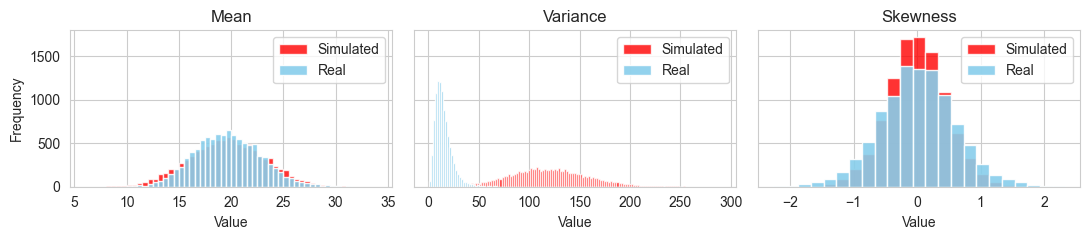

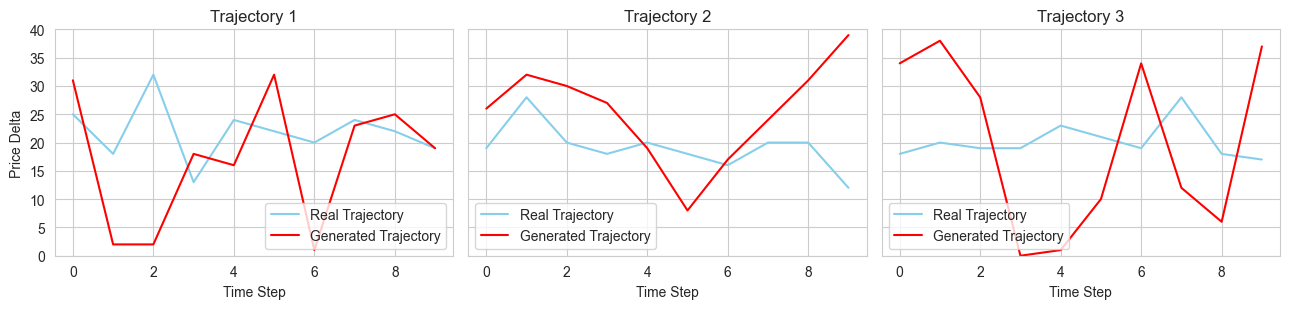

In [10]:
discriminator_init = Discriminator(sequence_length=10, hidden_size=256)
d_optimizer_init = optim.Adam(discriminator_init.parameters(), lr=3e-4, betas=(0.5, 0.999))

env_init = CustomEnv(train_data=train_data, token_size=token_size, 
                     discriminator=discriminator_init, d_optimizer=d_optimizer_init,
                     d_train_auto=True, d_max_updates=35
                     )

env_init = Monitor(env_init, filename=None) 

model_init = PPO(
    policy='MlpPolicy',
    env=env_init,
    verbose=0,

    n_steps=1000*10,
    batch_size=25*10,
    n_epochs=3,

    gamma=0.99,             # 0.99
    gae_lambda=0.95,

    clip_range=0.2,
    clip_range_vf=None,
    ent_coef=0.07,
    vf_coef=0.5,
    max_grad_norm=0.5,

    learning_rate=1e-4
)

sim_sequences = []

for sequence in val_data:
    
    _, _ = env_init.reset()
    done = False
    curr_seq_sim  = []

    action = sequence[0]

    while not done:
        action, _ = model_init.predict(action, deterministic=False)
        _, _, done, _, _ = env_init.step(action)
        curr_seq_sim.append(action.item())
    sim_sequences.append(curr_seq_sim)

init_seq = np.array(val_data[:,1:])
init_sim_seq = np.array(sim_sequences)

# Statistics for real and simulated trajectories
real_means, real_variances, real_std_devs, real_skew, real_kurtosis = calculate_statistics(init_seq)
sim_means, sim_variances, sim_std_devs, sim_skew, sim_kurtosis = calculate_statistics(init_sim_seq)

bin_start_mean = min(np.min(sim_means), np.min(real_means))
bin_stop_mean = max(np.max(sim_means), np.max(real_means))
bin_width_mean = 0.5
bin_edges_mean = np.arange(bin_start_mean, bin_stop_mean + bin_width_mean, bin_width_mean)

bin_start_var = min(np.min(sim_variances), np.min(real_variances))
bin_stop_var = max(np.max(sim_variances), np.max(real_variances))
bin_width_var = 2
bin_edges_var = np.arange(bin_start_var, bin_stop_var + bin_width_var, bin_width_var)

bin_start_skew = min(np.min(sim_skew), np.min(real_skew))
bin_stop_skew = max(np.max(sim_skew), np.max(real_skew))
bin_width_skew = 0.2
bin_edges_skew = np.arange(bin_start_skew, bin_stop_skew + bin_width_skew, bin_width_skew)

fig, axs = plt.subplots(1, 3, figsize=(11, 2.5))

# Plot 1: Mean Distribution
axs[0].hist(sim_means, bins=bin_edges_mean, alpha=0.8, label='Simulated', color='red')
axs[0].hist(real_means, bins=bin_edges_mean, alpha=0.9, label='Real', color='skyblue')
axs[0].legend(loc='upper right')
axs[0].set_title('Mean')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')
axs[0].set_ylim(0,1800)

# Plot 1: Variance Distribution
axs[1].hist(sim_variances, bins=bin_edges_var, alpha=0.8, label='Simulated', color='red')
axs[1].hist(real_variances, bins=bin_edges_var, alpha=0.9, label='Real', color='skyblue')
axs[1].legend(loc='upper right')
axs[1].set_title('Variance')
axs[1].set_xlabel('Value')
axs[1].set_ylim(0,1800)
axs[1].tick_params(labelleft=False)

# Plot 2: Skewness Distribution
axs[2].hist(sim_skew, bins=bin_edges_skew, alpha=0.8, label='Simulated', color='red')
axs[2].hist(real_skew, bins=bin_edges_skew, alpha=0.9, label='Real', color='skyblue')
axs[2].legend(loc='upper right')
axs[2].set_title('Skewness')
axs[2].set_xlabel('Value')
axs[2].set_ylim(0,1800)
axs[2].tick_params(labelleft=False)
plt.subplots_adjust(wspace=0.05)  # Reduce space between plots
plt.tight_layout()
plt.show()

# Create the subplots
fig, axes = plt.subplots(1, 3, figsize=(13, 3.2))  # 1 row, 3 columns
axes = axes.flatten()

# Plot the real and simulated trajectories
for i in range(3):
    axes[i].plot(init_seq[i+2], label='Real Trajectory', color='skyblue', linewidth=1.5)
    axes[i].plot(init_sim_seq[i+2], label='Generated Trajectory', color='red', linewidth=1.5)
    axes[i].legend(loc='best')
    axes[i].set_title(f'Trajectory {i+1}')
    axes[i].set_ylim(0, 40)
    axes[i].set_xlabel('Time Step')
    
    if i == 0:  # Only set y-axis label on the first plot
        axes[i].set_ylabel('Price Delta')
    else:
        axes[i].tick_params(labelleft=False)  # Remove y-axis labels and ticks for the 2nd and 3rd plots

# Adjust spacing between plots to bring them closer
plt.subplots_adjust(wspace=0)  # Reduce space between plots
plt.tight_layout()
plt.show()


Mean Wasserstein Distance: 0.0893
Worst Timestep: 5


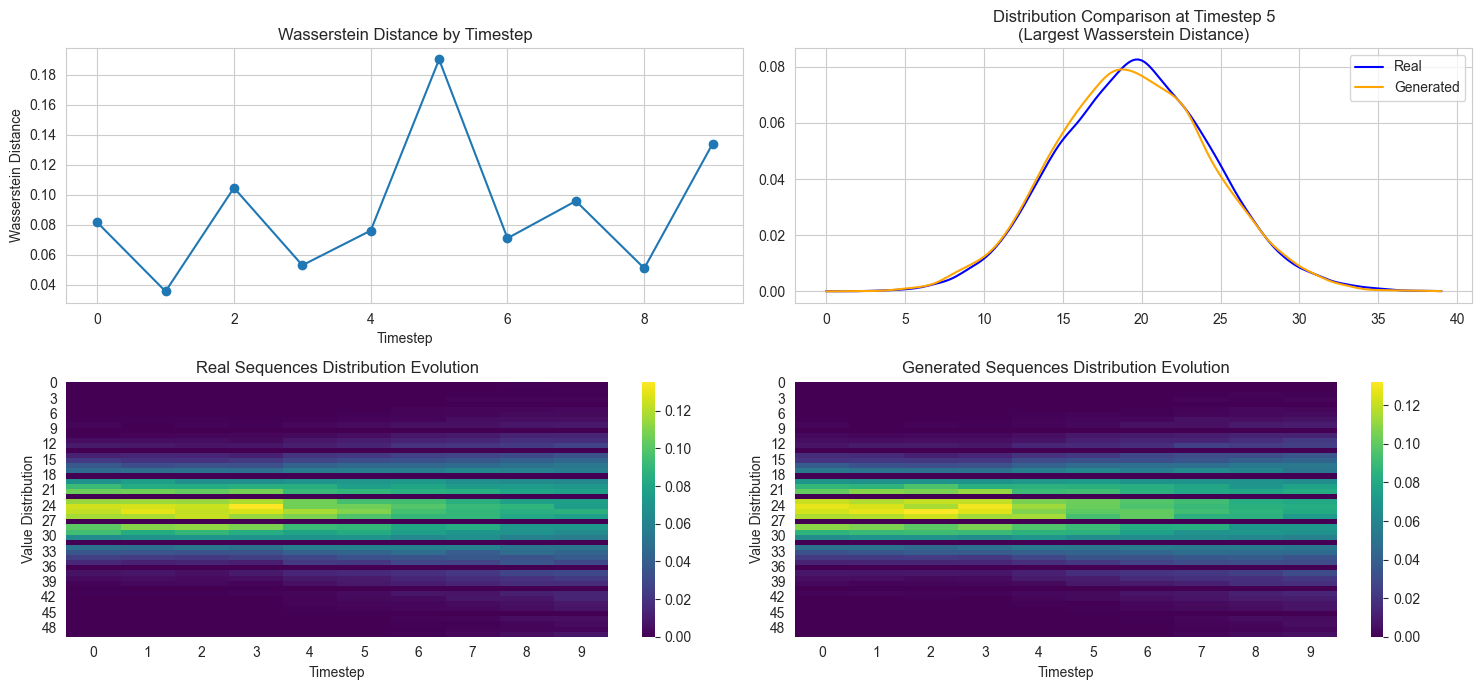

In [22]:
# Analyze distributions
results = analyze_timestep_distributions(init_seq, test_data[:,1:])
# Print summary statistics
print(f"\nMean Wasserstein Distance: {results['mean_wasserstein']:.4f}")
print(f"Worst Timestep: {results['worst_timestep']}")

plt.show()

#### Sequential Pattern Analysis

Most interpretable and directly related to trading patterns
Compare frequencies of up/down patterns (e.g., up-up-down vs down-up-up)